# Description of the first homework assignment  

Consider a picture representing a white sheet of A4 paper with some handwritten numbers in a dark color (they have different sizes, but they are all oriented in the same direction, which is aligned with one of the edges of the paper).  Consider the attached pictures as examples. Some are easy, others are harder. Note that the paper might be pictured at an angle or from a slanted perspective.  In all pictures the four edges of the paper are clearly visible, but might be incomplete.

Write a notebook that, given a directory, will process all images in that directory and extract all digits it can find from each picture. For each file, it should then print:
- the name of the file, followed by  
- each of the digits that has been identified on that sheet of paper, from top to bottom.

### Examples
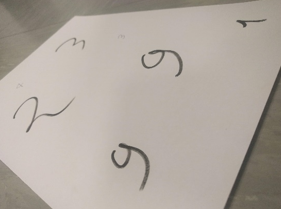 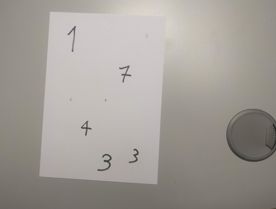 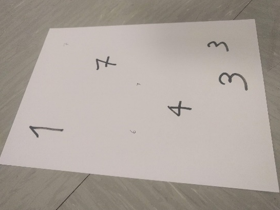 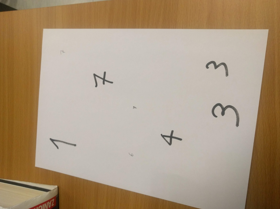

## Imports

In [292]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import ipywidgets as widgets
import math
import random
import itertools

from typing import Self

### Helper class: Image Collection 

In [293]:
class ImageItem:
    def __init__(self, path: pathlib.Path):
        self.path = path
    
    def load(self):
        return self.__load(self.path)
    
    def load_grayscale(self):
        return skimage.color.rgb2gray(self.__load(self.path))        
    
    @staticmethod
    def __load(path: pathlib.Path):
        return skimage.io.imread(path)


class ImageCollection:
    def __init__(self, dir_path: pathlib.Path | str | None = None):
        self.__entries: list[ImageItem] = self.__scan_dir(dir_path) if dir_path else []
    
    def __len__(self) -> int:
        return len(self.__entries)

    def __getitem__(self, key: slice | str | int) -> Self | pathlib.Path:
        if isinstance(key, slice):
            return ImageCollection().__add_entries(self.__entries[key])
        
        if isinstance(key, str):
            return self.__get_item_by_name(key)
        
        if isinstance(key, int):
            return self.__entries[key]
        
        raise TypeError(f'Type {type(key)} not supported!')

    def __add_entries(self, entries: list):
        self.__entries.extend(entries)
        
        return self

    def __scan_dir(self, dir_path: pathlib.Path | str):
        return [ImageItem(path) for path in pathlib.Path(dir_path).rglob('*') if path.suffix == '.jpg']
    
    def __get_item_by_name(self, name: str) -> ImageItem | None:
        item: ImageItem
        for item in self.__entries:
            if item.path.name == name:
                return item
        
        return None

### Helper class: LineItem

In [294]:
class LineItem:
    def __init__(self, p0, p1):
        self.p0: np.array = np.array([*p0, 1.0], dtype=float)
        self.p1: np.array = np.array([*p1, 1.0], dtype=float)
        self.length: np.float64 = self.__calc_euclidean_distance(self.p0, self.p1)
        self.slope: float = self.__calc_slope(self.p0, self.p1)
        self.slope_rad: float = math.atan(self.slope)
        self.intercept: np.array[float] = self.__calc_intercept(self.p1, self.slope)
        self.h_coords: np.array[float] = np.cross(self.p0, self.p1)
        self.midpoint: np.array = (self.p0 + self.p1) / 2

    def __str__(self):
        return f'P0: {self.p0}, P1: {self.p1}, H-Coords: {self.h_coords} , Length: {self.length:.3f}, Slope: {self.slope:.3f}, Slope (Rad): {self.slope_rad:.3f}, X-Intercept: {self.intercept[0]:.3f}, Y-Intercept: {self.intercept[1]:.3f}'

    @staticmethod
    def __calc_intercept(point: tuple[int], slope: float) -> float:
        x = math.inf if slope == 0.0 else point[0] - point[1] / slope
        y = slope if slope == math.inf else point[1] - slope * point[0]

        return np.array([x, y])

    @staticmethod
    def __calc_euclidean_distance(p0: np.array, p1: np.array):
        return np.linalg.norm(p0[:-1] - p1[:-1])

    @staticmethod
    def __calc_slope(point_0: np.array, point_1: np.array) -> float:     
        if point_1[0] == point_0[0]:  # if parallel to y
            return math.inf

        return (point_1[1] - point_0[1]) / (point_1[0] - point_0[0])

### Image collection

In [295]:
images = ImageCollection(pathlib.Path.cwd())

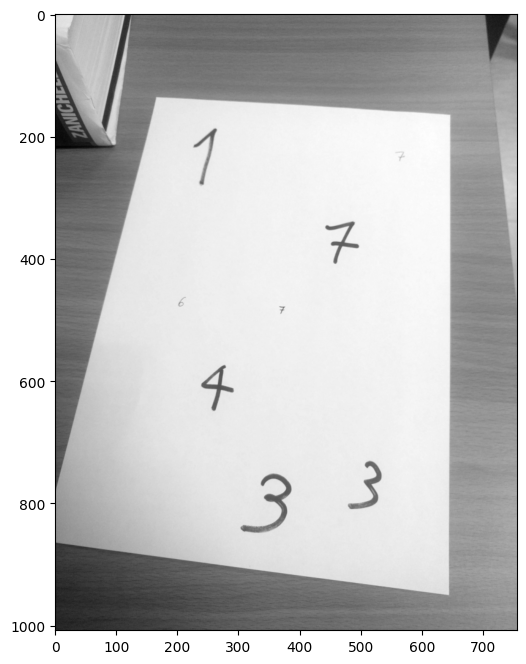

In [334]:
img = images['IMG_20190312_184032.jpg'].load_grayscale()
img = skimage.transform.rescale(img, 0.250)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.imshow(img, cmap='gray')

### Adjust contrast  
For better black & white values

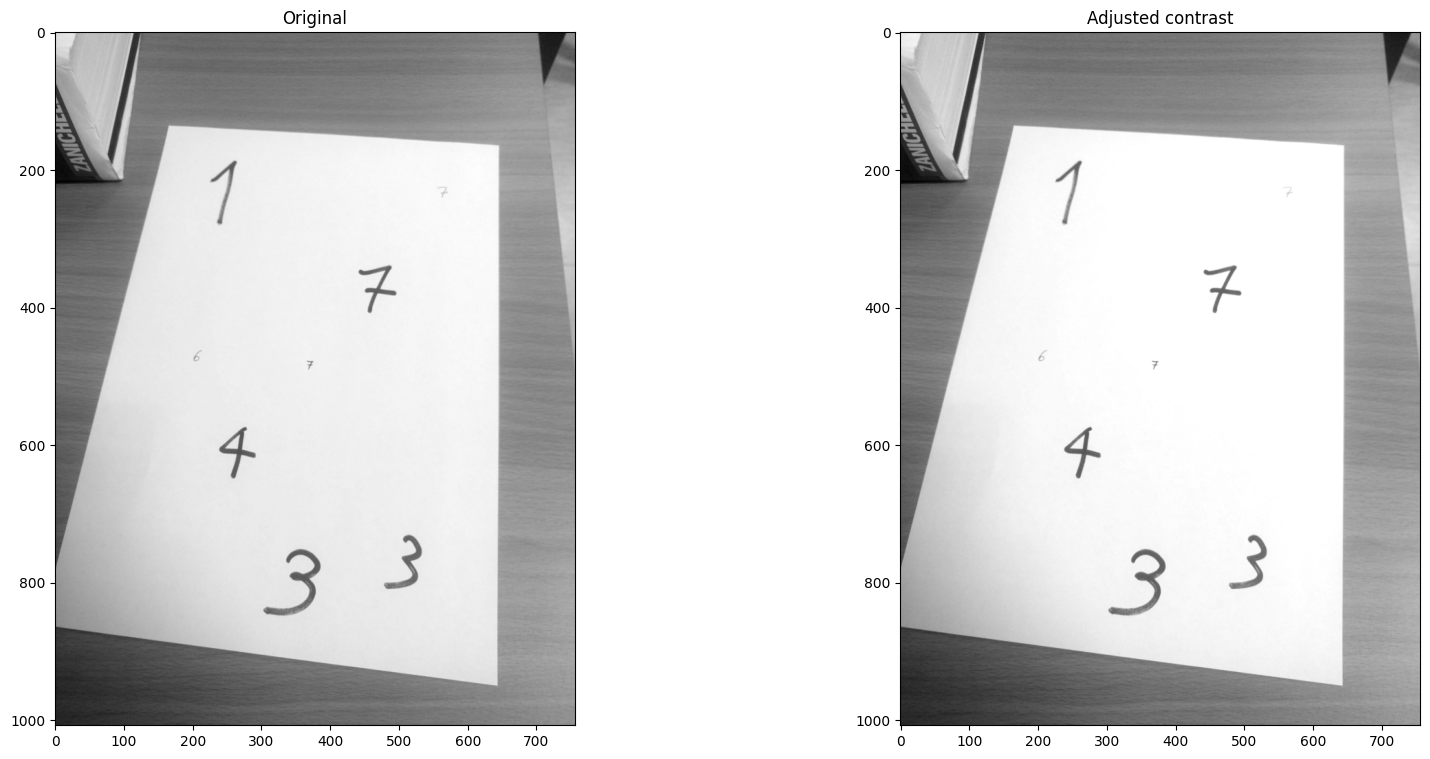

In [335]:
p2, p98 = np.percentile(img, (0, 80))
img_adjusted = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 9))
ax0.set_title("Original")
ax0.imshow(img, cmap='gray')
ax1.set_title("Adjusted contrast")
ax1.imshow(img_adjusted, cmap='gray')

### Edges

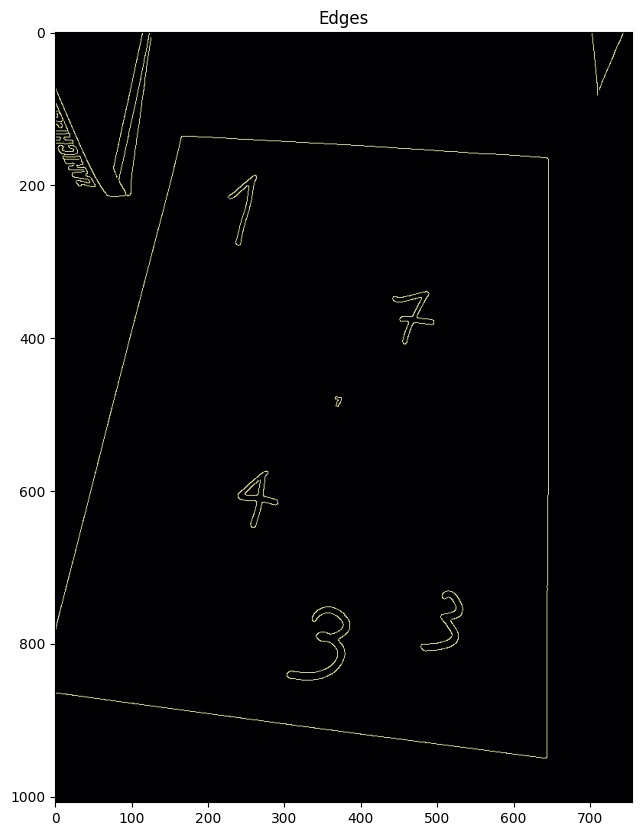

In [336]:
# Adjust contrast for better black & white values
im_edges = skimage.feature.canny(img_adjusted, low_threshold=0.1, high_threshold=0.6, sigma=1.4)
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax0.set_title("Edges")
ax0.imshow(im_edges, cmap='inferno')

### Detect borders of the paper

In [337]:
@widgets.interact(filter_threshold=widgets.IntSlider(value=90, min=0, max=1000.0, step=1),
                  filter_min_line_length_px=widgets.IntSlider(value=120, min=0, max=1000, step=1),
                  filter_min_line_gap_px=widgets.IntSlider(value=30, min=0, max=200, step=1))
def f(filter_threshold, filter_min_line_length_px, filter_min_line_gap_px):
    lines: list[tuple] = skimage.transform.probabilistic_hough_line(im_edges, threshold=filter_threshold, line_length=filter_min_line_length_px, line_gap=filter_min_line_gap_px)
    print(len(lines))
    fig,ax = plt.subplots(figsize=(10,10))
    ax.imshow(im_edges,cmap="gray")    
    for ((x0,y0),(x1,y1)) in lines:
        ax.plot([x0,x1],[y0,y1],'r-')
        
    plt.show() 



interactive(children=(IntSlider(value=90, description='filter_threshold', max=1000), IntSlider(value=120, desc…

In [338]:
def group_lines(lines: list[LineItem]):
    grouped_lines = _group_lines_with_slope(lines)
    grouped_lines = _finegroup_with_distance(grouped_lines)
    
    return grouped_lines

def _finegroup_with_distance(grouped_lines: list[list[np.array]]) -> list[list[LineItem]]:
    group_range_distance: int = 50
    fine_grouped_lines: list = []

    curr_line_group: list[LineItem]
    for curr_line_group in grouped_lines:
        curr_line_group = sorted(curr_line_group, key=lambda line: (line.intercept[1]))
        # Where do we have the intersection nearest to 0
        active_intersection: int = 0 if abs(curr_line_group[0].intercept[0]) < abs(curr_line_group[0].intercept[1]) else 1

        idx_reference: int = 0
        curr_line: LineItem
        for idx, curr_line in enumerate(curr_line_group):
            if abs(curr_line_group[idx_reference].intercept[active_intersection] - curr_line.intercept[active_intersection]) > group_range_distance:
                fine_grouped_lines.append(curr_line_group[idx_reference:idx])
                idx_reference = idx
                continue
        
        fine_grouped_lines.append(curr_line_group[idx_reference:])
        
    return fine_grouped_lines

def _group_lines_with_slope(lines: list[LineItem]) -> list[list[LineItem]]:
    group_range_deg: float = 25
    group_range_rad: float = group_range_deg * math.pi / 180

    lines = sorted(lines, key=lambda line: (line.slope))

    slope_groups: list = []
    idx_reference: int = 0
    for idx, line in enumerate(lines):
        if lines[idx_reference].slope_rad + group_range_rad < line.slope_rad:
            slope_groups.append(lines[idx_reference:idx])
            idx_reference = idx
            continue

    slope_groups.append(lines[idx_reference:])

    return slope_groups

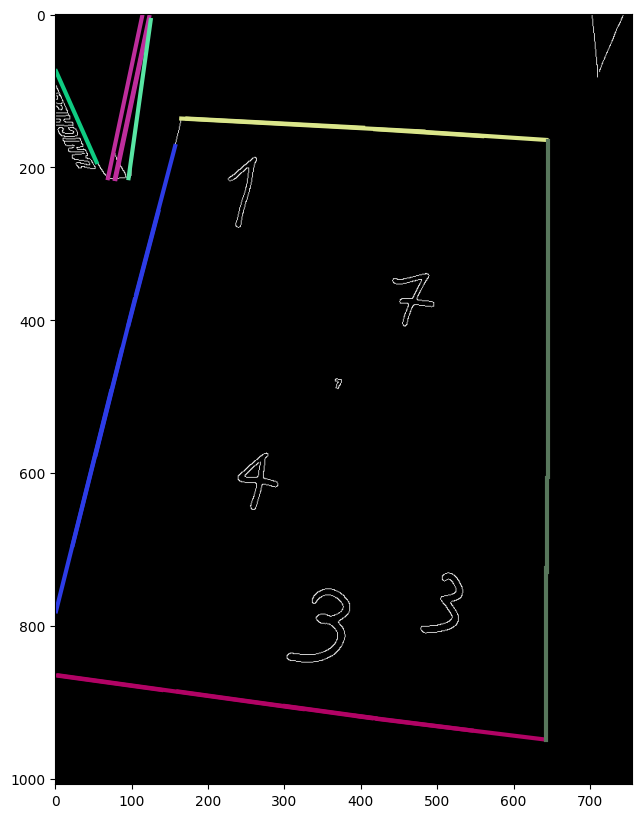

In [359]:
lines: list[LineItem] = [LineItem(p0=line[0], p1=line[1]) for line in skimage.transform.probabilistic_hough_line(im_edges, threshold=90, line_length=110, line_gap=40)]
grouped_lines = group_lines(lines)

# for idx, group in enumerate(grouped_lines):
#    print("\n".join(f'Group {idx} --> {str(line)}' for line in group))

fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(im_edges, cmap="gray")
for lines in grouped_lines:
    random_color = (random.random(), np.random.rand(), random.random())
    for line in lines:
        ax.plot([line.p0[0], line.p1[0]], [line.p0[1], line.p1[1]], color = random_color, linewidth=3)
        
plt.show()

### Merge group of lines into one line

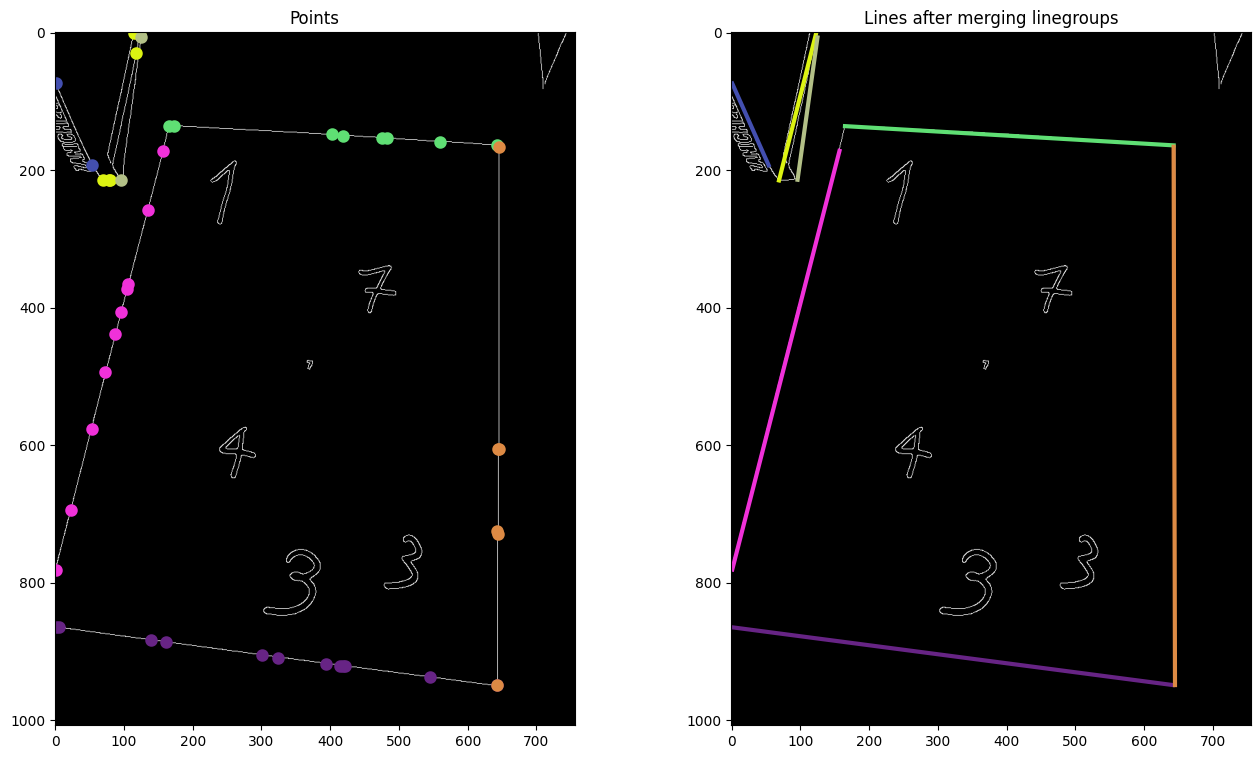

In [360]:
def merge_groups(grouped_lines: list[list[LineItem]]) -> list[LineItem]:
    merged_lines: list = []
    for lines in grouped_lines:
        points = [p for line in lines for p in (line.p0, line.p1)]
        x_min = min([point[0] for point in points])
        x_max = max([point[0] for point in points])
        y_min = min([point[1] for point in points])
        y_max = max([point[1] for point in points])

        if lines[0].slope > 0:
            merged_lines.append(LineItem((x_min, y_min), (x_max, y_max)))
        else:
            merged_lines.append(LineItem((x_max, y_min), (x_min, y_max)))
    
    return merged_lines

merged_lines: list[LineItem] = merge_groups(grouped_lines)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax0.imshow(im_edges,cmap="gray")
ax1.imshow(im_edges,cmap="gray")
ax0.set_title("Points")
ax1.set_title("Lines after merging linegroups")

for group, merge in zip(grouped_lines, merged_lines):
    random_color = (1 - np.random.rand(), np.random.rand(), 1.0 - random.random())
    for line in group:
        ax0.scatter(line.p0[0], line.p0[1], color = random_color, linewidth=3)
        ax0.scatter(line.p1[0], line.p1[1], color = random_color, linewidth=3)
    
    ax1.plot([merge.p0[0], merge.p1[0]], [merge.p0[1], merge.p1[1]], color = random_color, linewidth=3)

plt.show()

#### Detect rectangle
Find the four lines which are nearest to the center of the image

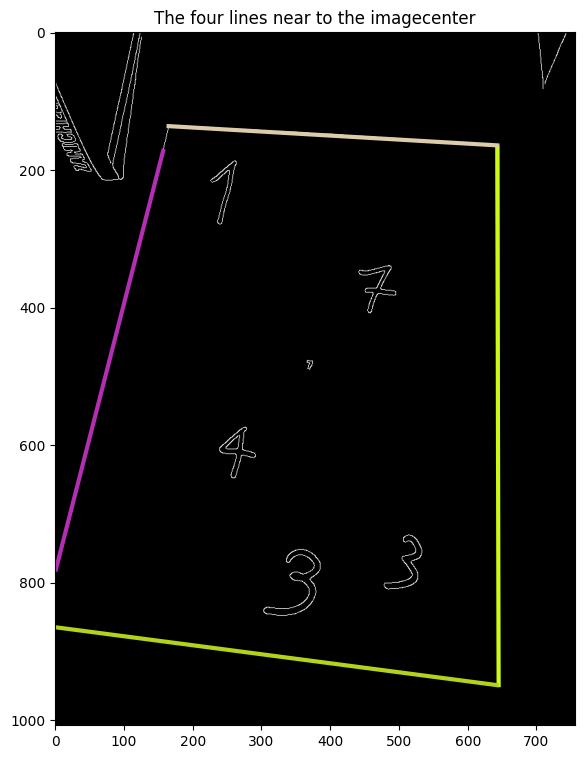

In [361]:
def get_the_four_nearest_lines_to_the_center(canvas: np.array, lines: list[LineItem]):
    lines_with_distance: list[tuple] = [(line, np.linalg.norm(np.array(canvas.shape, dtype=float)[::-1] / 2 - line.midpoint[:-1])) for line in lines]
    sorted_lines: list[tuple] = sorted(lines_with_distance, key=lambda x: x[1])
    
    return [line[0] for line in sorted_lines[:4]]

filtered_lines: list[LineItem] = get_the_four_nearest_lines_to_the_center(im_edges, merged_lines)

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(20, 9))
ax0.imshow(im_edges,cmap="gray")
ax0.set_title("The four lines near to the imagecenter")

for line in filtered_lines:
    random_color = (1 - np.random.rand(), np.random.rand(), 1.0 - random.random())
    ax0.plot([line.p0[0], line.p1[0]], [line.p0[1], line.p1[1]], color = random_color, linewidth=3)
    
plt.show()

### Now detect crossing points

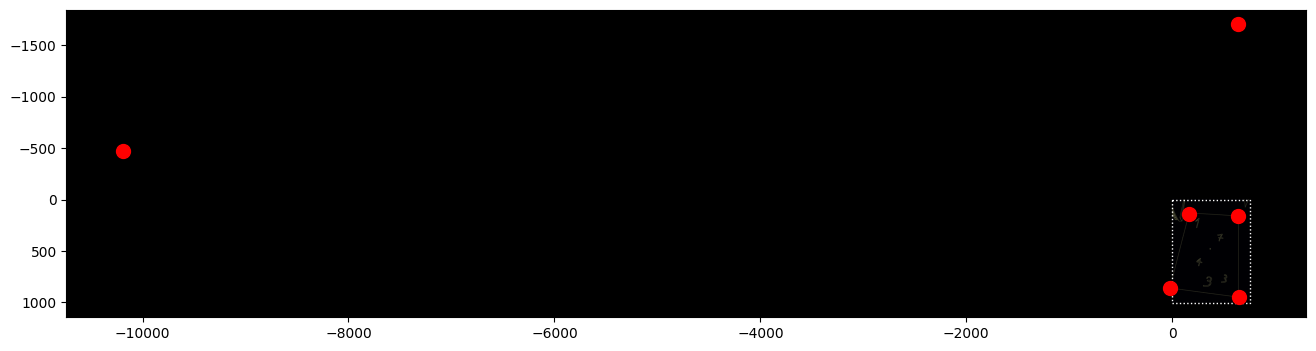

In [362]:
import matplotlib.patches as patches

def extract_all_intersections(combinations: list[tuple[LineItem]]) -> list[tuple]:
    intersections: list[tuple] = [np.cross(x[0].h_coords, x[1].h_coords) for x in combinations]
    return [(intersection[0]/intersection[2], intersection[1]/intersection[2]) for intersection in intersections]

all_combinations = list(itertools.combinations(filtered_lines, 2))
all_intersections = extract_all_intersections(all_combinations)

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax0.set_facecolor('black')
ax0.imshow(im_edges, cmap='inferno')
ax0.add_patch(patches.Rectangle((0, 0), im_edges.shape[1], im_edges.shape[0], linewidth=1, edgecolor='white', facecolor='none', linestyle=':'))

for idx, intersection in enumerate(all_intersections):
   ax0.plot(intersection[0], intersection[1], "r.", markersize=20.0)
